# Day 5: Feature Transformations

## 🎯 Learning Objectives
- Log, power transformations
- Normalization techniques
- Handling non-stationarity

---

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

df = data[['Close', 'Volume']].copy()
df['return'] = df['Close'].pct_change()
df = df.dropna()
print(f"✅ Data: {len(df)} days")

✅ Data: 1253 days


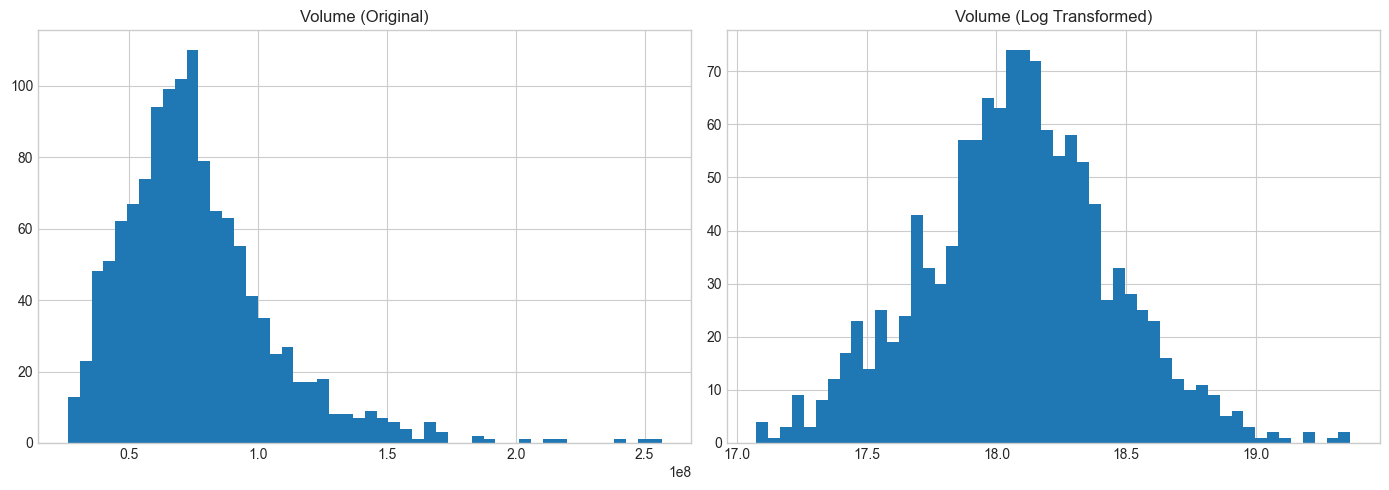

Original skewness: 1.45
Log skewness: 0.05


In [10]:
# Log transformation for skewed features
df['volume_log'] = np.log1p(df['Volume'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['Volume'], bins=50)
axes[0].set_title('Volume (Original)')
axes[1].hist(df['volume_log'], bins=50)
axes[1].set_title('Volume (Log Transformed)')
plt.tight_layout()
plt.show()

print(f"Original skewness: {df['Volume'].skew():.2f}")
print(f"Log skewness: {df['volume_log'].skew():.2f}")

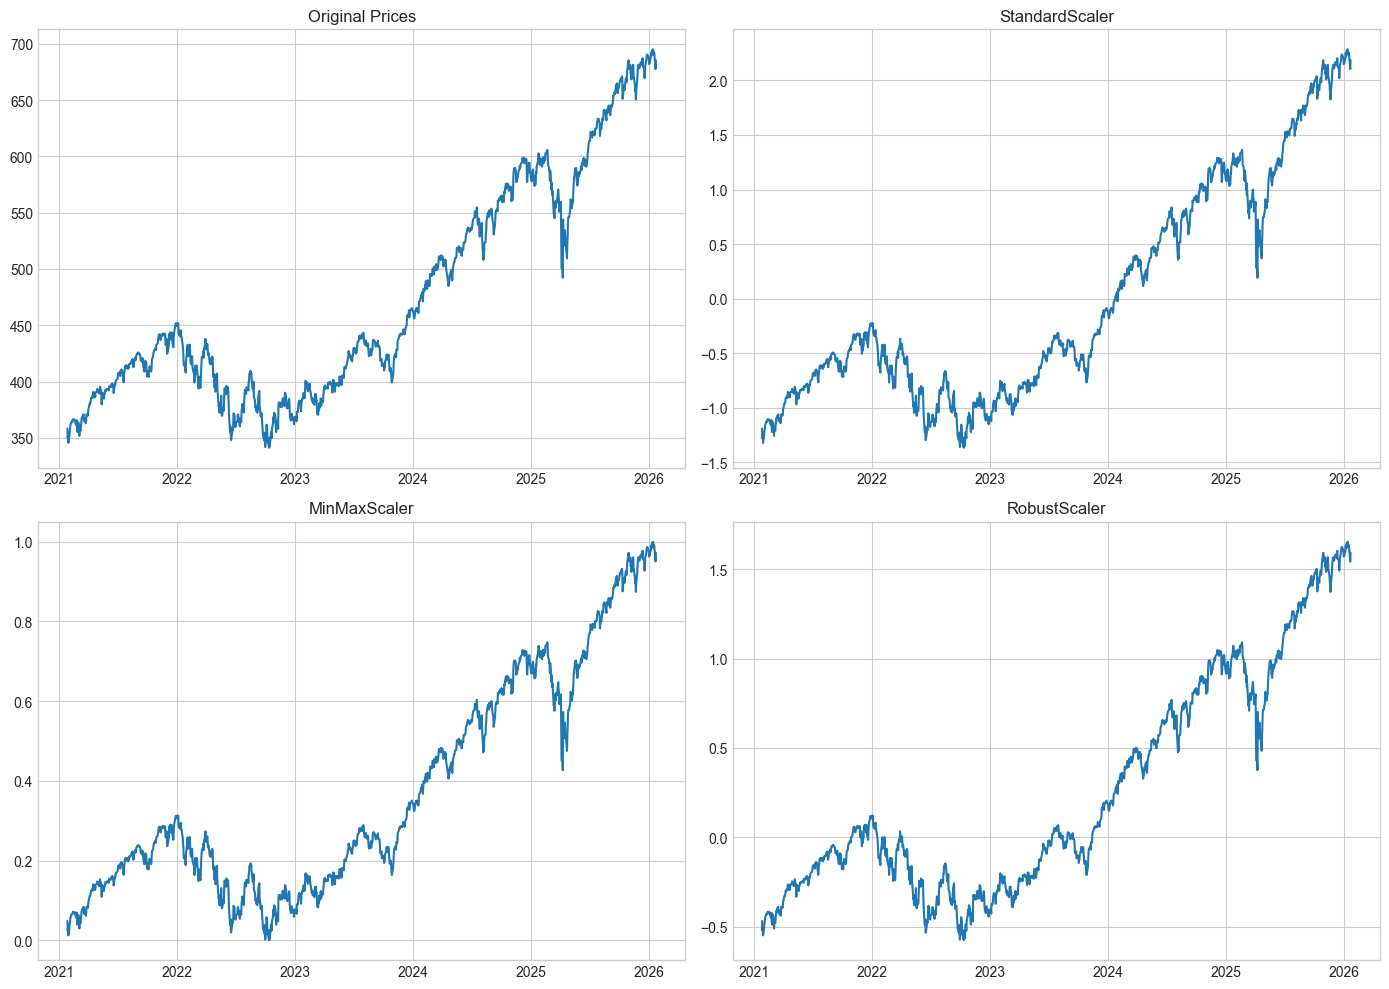

In [11]:
# Compare scalers
price_data = df['Close'].values.reshape(-1, 1)

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].plot(df.index, df['Close'])
axes[0,0].set_title('Original Prices')

for ax, (name, scaler) in zip(axes.flatten()[1:], scalers.items()):
    scaled = scaler.fit_transform(price_data)
    ax.plot(df.index, scaled)
    ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

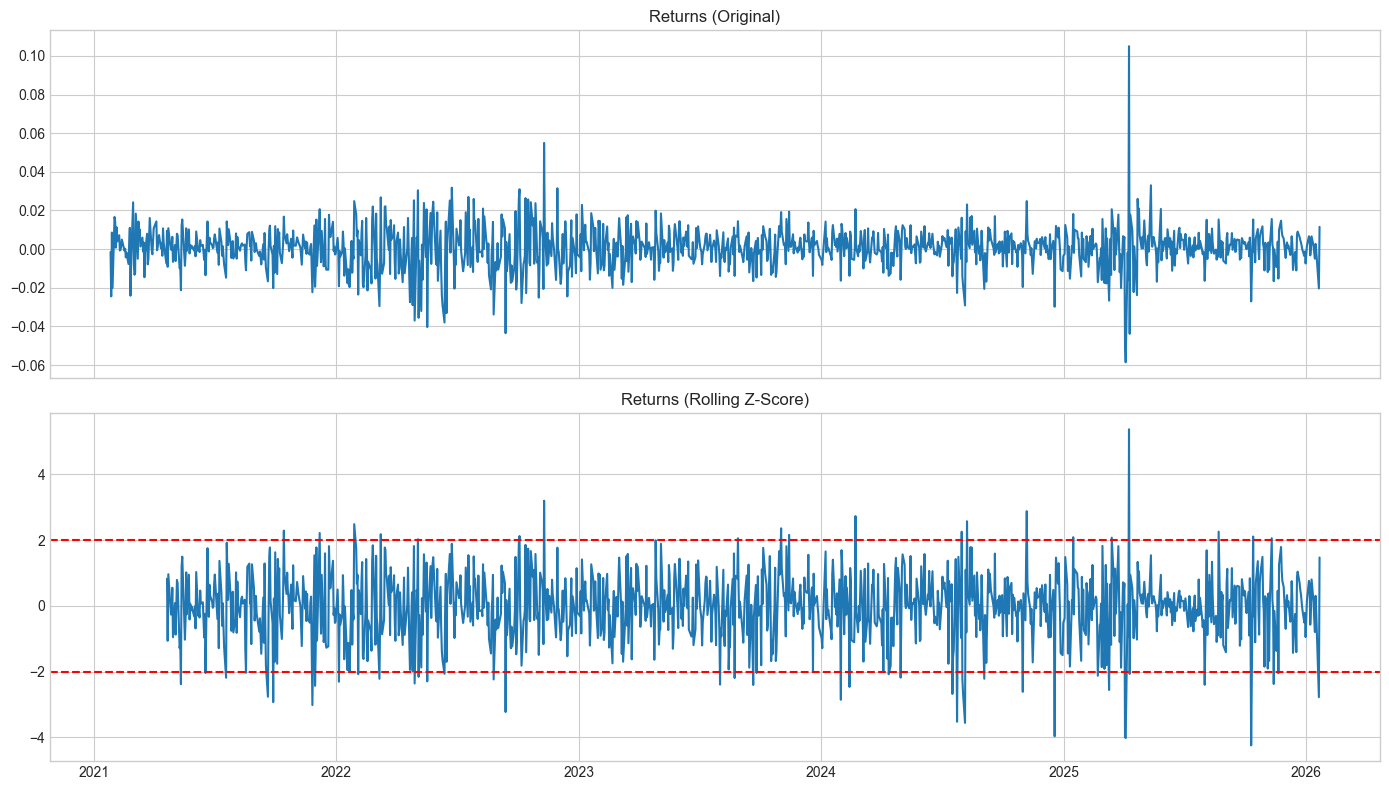

In [12]:
# Rolling Z-score (adaptive normalization)
window = 60
df['return_zscore'] = (df['return'] - df['return'].rolling(window).mean()) / df['return'].rolling(window).std()
df['volume_zscore'] = (df['Volume'] - df['Volume'].rolling(window).mean()) / df['Volume'].rolling(window).std()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
axes[0].plot(df.index, df['return'])
axes[0].set_title('Returns (Original)')
axes[1].plot(df.index, df['return_zscore'])
axes[1].axhline(y=2, color='r', linestyle='--')
axes[1].axhline(y=-2, color='r', linestyle='--')
axes[1].set_title('Returns (Rolling Z-Score)')
plt.tight_layout()
plt.show()

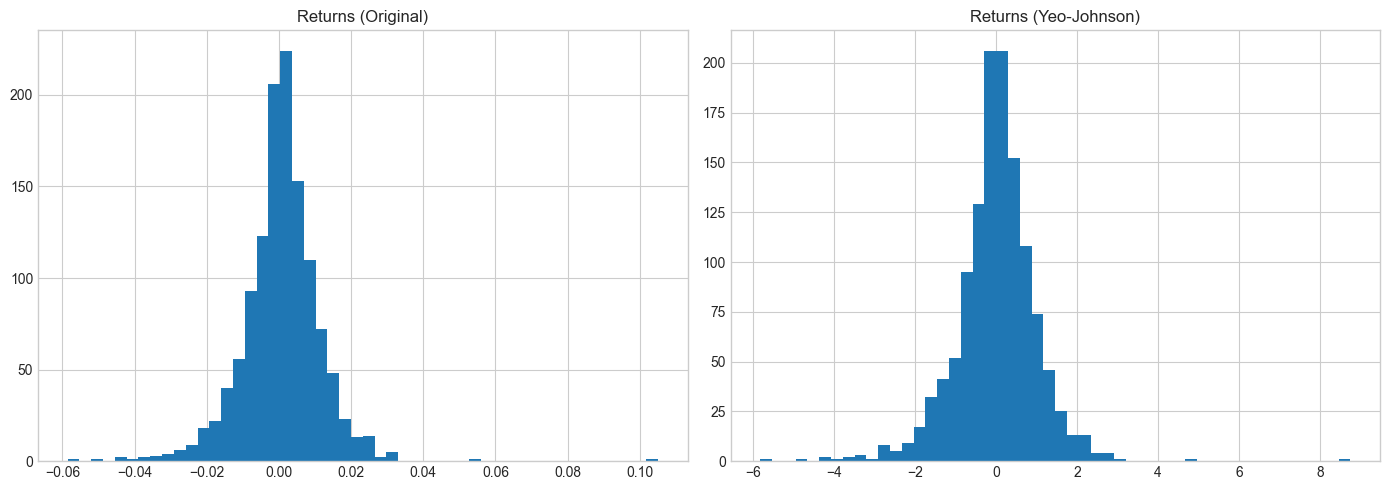

In [13]:
# Power transformation (Box-Cox, Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
df['return_power'] = pt.fit_transform(df['return'].values.reshape(-1, 1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['return'].dropna(), bins=50)
axes[0].set_title('Returns (Original)')
axes[1].hist(df['return_power'].dropna(), bins=50)
axes[1].set_title('Returns (Yeo-Johnson)')
plt.tight_layout()
plt.show()

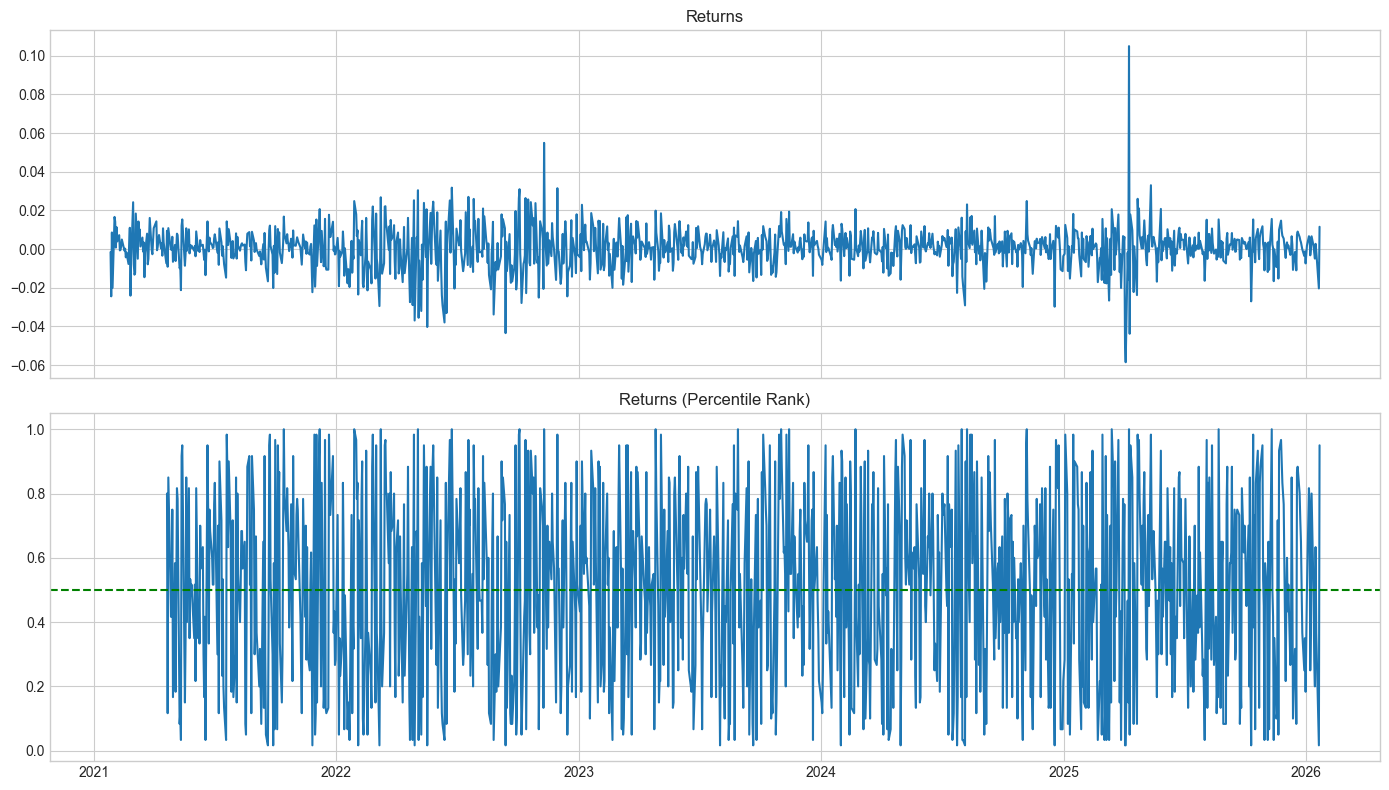

In [14]:
# Rank transformation (percentile)
df['return_rank'] = df['return'].rolling(60).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]) / 100)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
axes[0].plot(df.index, df['return'])
axes[0].set_title('Returns')
axes[1].plot(df.index, df['return_rank'])
axes[1].axhline(y=0.5, color='g', linestyle='--')
axes[1].set_title('Returns (Percentile Rank)')
plt.tight_layout()
plt.show()

In [15]:
# Build model comparing transformations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df['target'] = np.sign(df['return'].shift(-1)).map({1: 1, -1: 0, 0: 1})
df = df.dropna()

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Test different feature sets
feature_sets = {
    'Raw': ['return', 'Volume'],
    'Z-Score': ['return_zscore', 'volume_zscore'],
    'Mixed': ['return_zscore', 'return_rank', 'volume_log']
}

print("\n" + "="*60)
print("TRANSFORMATION COMPARISON")
print("="*60)

for name, features in feature_sets.items():
    X_train = train[features].dropna()
    X_test = test[features].dropna()
    y_train = train.loc[X_train.index, 'target']
    y_test = test.loc[X_test.index, 'target']
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name}: {acc:.1%}")


TRANSFORMATION COMPARISON
Raw: 53.1%
Z-Score: 51.5%
Mixed: 55.2%


In [16]:
# Today's signal
print("\n" + "="*60)
print(f"📊 TRANSFORMATION-BASED SIGNAL")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nReturn Z-Score: {df['return_zscore'].iloc[-1]:.2f}")
print(f"Return Percentile: {df['return_rank'].iloc[-1]:.1%}")
print(f"Volume Z-Score: {df['volume_zscore'].iloc[-1]:.2f}")

# Extreme signal
if abs(df['return_zscore'].iloc[-1]) > 2:
    print(f"\n⚠️ Extreme move detected (|Z| > 2)")


📊 TRANSFORMATION-BASED SIGNAL

Date: 2026-01-20

Return Z-Score: -2.78
Return Percentile: 1.7%
Volume Z-Score: 1.41

⚠️ Extreme move detected (|Z| > 2)


---
## 📅 Tomorrow: Target Engineering